In [1]:
%matplotlib inline

In [2]:
from PIL import Image
import cv2 
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import interact, HBox

In [3]:
import glob, os

laser_samples = []
os.chdir("../res/cal_theta_in/")
for file in sorted(glob.glob("*")):
    laser_samples.append(file)

In [4]:
def disp_file(path):
    # In OpenCV, images are in BGR
    # In Pillow, images are in RGB 
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
    img = cv2.resize(img, (480, 360))
    display(Image.fromarray(img))

# Display cv2 image
def disp_img(cv_img):
#     cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
    cv_img = cv2.resize(cv_img, (480, 360))
    display(Image.fromarray(cv_img))


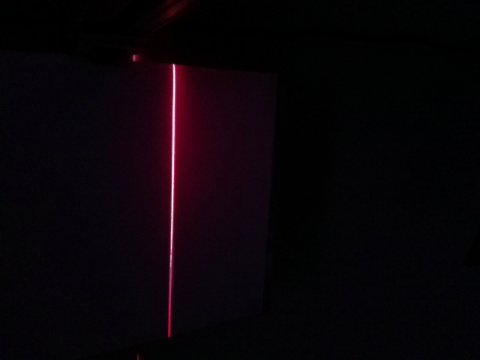

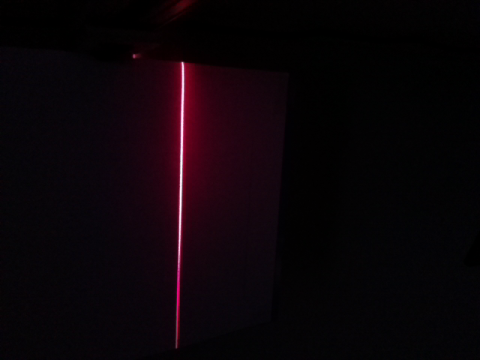

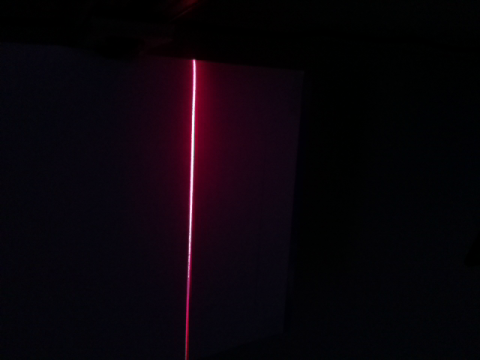

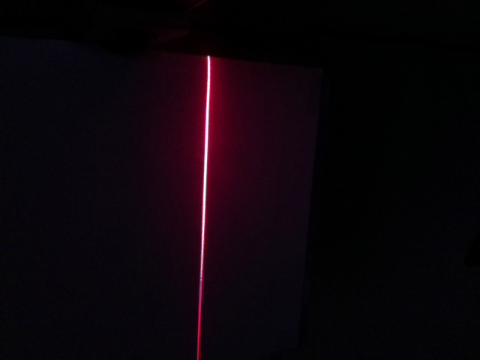

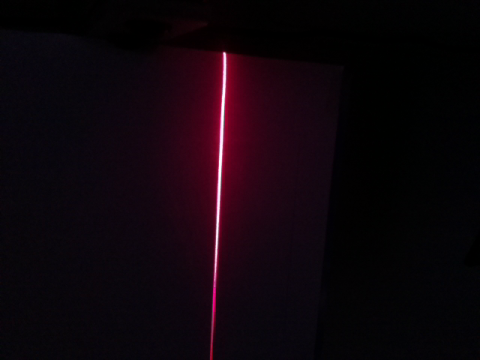

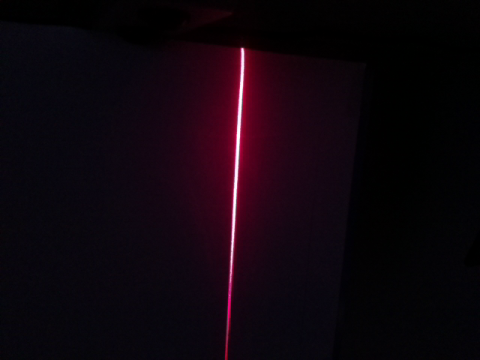

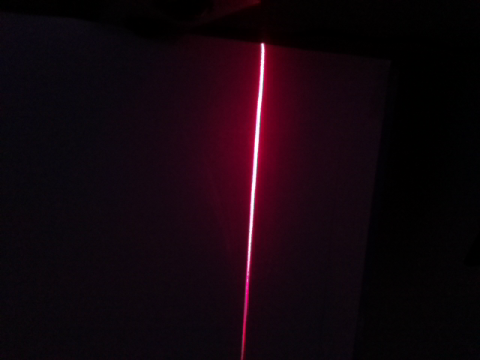

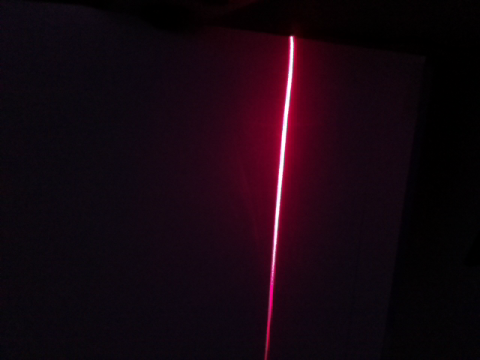

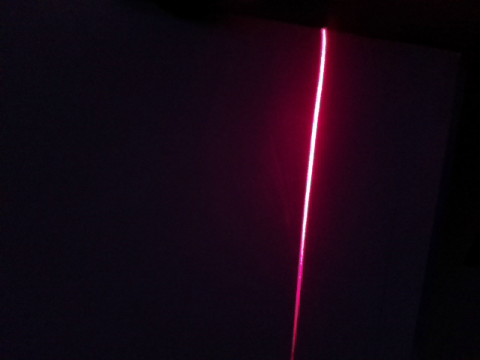

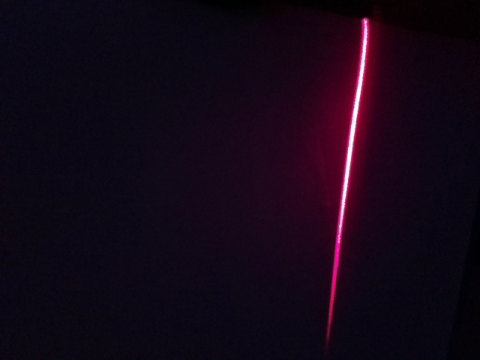

In [5]:
for file in laser_samples:
    disp_file(path=file)


In [6]:
for file in laser_samples:
    print(file)

dist_01_26cm.png
dist_02_24cm.png
dist_03_22cm.png
dist_04_20cm.png
dist_05_18cm.png
dist_06_16cm.png
dist_07_14cm.png
dist_08_12cm.png
dist_09_10cm.png
dist_10_8cm.png


In [7]:
def extract_laser(frame): 
    
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # define range of blue color in HSV
    lower_colour = np.array([146, 62, 0])
    upper_colour = np.array([255, 255, 255])
    
    # Threshold the HSV image to get only get red colour
    mask = cv2.inRange(hsv, lower_colour, upper_colour)
    
    # Isolate the red channel
    img = frame[...,2]
    ret,img = cv2.threshold(img,144,255,0)

    # Create emptry array of zeros of same size as img
    out = np.zeros_like(img)

    # For each row, get the position of the highest intensity
    bppr = np.argmax(img, axis=1)

    # Set the highest intensity pixel locations to 255
    out[np.arange(bppr.shape[0]), bppr] = 255
    
    # Bitwise-AND mask and original image
#     res = cv2.bitwise_and(out,out, mask= mask)
    
    return out, bppr


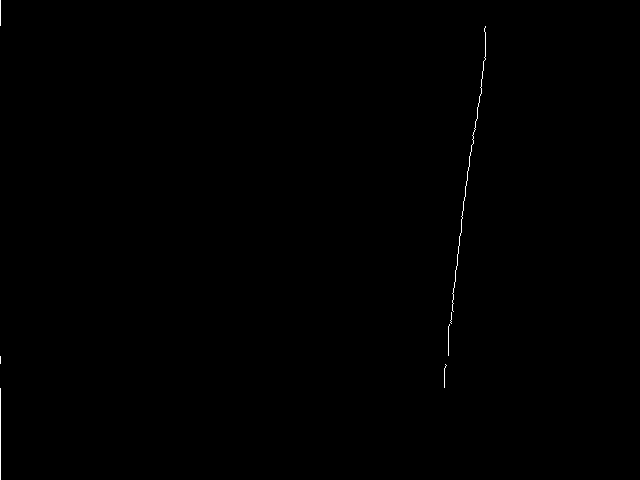

In [8]:
img = cv2.imread(laser_samples[9])
img, POI  = extract_laser(img)

display(Image.fromarray(img))

In [11]:
(h, w) = img.shape
print(w, h)

640 480


In [12]:
centre_x = w/2
centre_y = h/2 
print(centre_x, centre_y)

320.0 240.0


In [13]:
# Distance from y axis
pix_dist = POI - centre_x
pix_dist.shape

(480,)

In [14]:
x = 10.16 # dist b/w camera and laser is 4 inches 
D = np.arange(26, 6, -2) # 26 to 8 
offset = 0 # dist b/w camera and test rig

theta = np.arctan(D/x)
print(theta)

[1.19827275 1.17033821 1.13815798 1.10076922 1.05693101 1.0050383
 0.9430201  0.86824062 0.77746182 0.66701163]


In [15]:
# we use 10 images, and we are looking at every row
pix_dist_mat = np.empty((D.size, h))
pix_dist_mat.shape

(10, 480)

In [17]:
for count, file in enumerate(laser_samples):
    img = cv2.imread(laser_samples[count])
    img, POI  = extract_laser(img)
    pix_dist_mat[count] = POI - centre_x
#     pix_dist_mat[count] = np.trim_zeros(POI)
    

In [15]:
# pix_dist_mat[:,300]

In [18]:
@interact
def plot(col=(0,480)):
    plt.title("Theta calibration") 
    plt.xlabel("Hor distance from pixel to centre of frame (pixels)") 
    plt.ylabel("Theta (rad)") 
    plt.plot(pix_dist_mat[:,col], theta, "ob") 
    plt.show()
    
# The usable rows are between 86 and 335

interactive(children=(IntSlider(value=240, description='col', max=480), Output()), _dom_classes=('widget-inter…

## Method 1. Normal Equation

(10, 2)
(10, 1)
(2, 1)
[[ 1.0062512 ]
 [-0.00214485]]


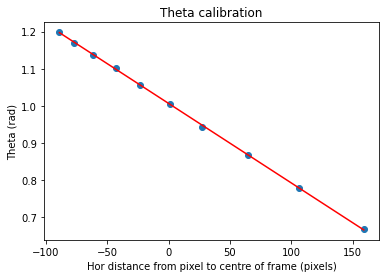

In [17]:
X = pix_dist_mat[:, 100].reshape(pix_dist_mat.shape[0], 1)
ones = np.ones((pix_dist_mat.shape[0],1))
X = np.hstack((ones, X))

Y = theta.reshape(theta.shape[0], 1)

print(X.shape)
print(Y.shape)

coeff = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
print(coeff.shape)
print(coeff)

y_line = X.dot(coeff)

plt.scatter(X[:,1], Y)
plt.plot(X[:,1], y_line, 'r')
plt.title('Theta calibration')
plt.xlabel('Hor distance from pixel to centre of frame (pixels)')
plt.ylabel('Theta (rad)')

plt.show()

## Method 2. np.polyfit

(10,)
(10,)


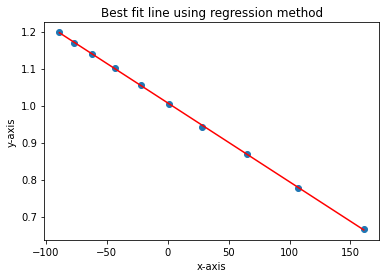

In [18]:
X = pix_dist_mat[:, 86]
Y = theta

print(X.shape)
print(Y.shape)

# coeff = np.polyfit(X, Y, 1)
coeff = np.polynomial.polynomial.polyfit(X, Y.T, 1)
y_line = coeff[0] + coeff[1] * X

plt.scatter(X, Y)
plt.plot(X, y_line, 'r')
plt.title('Best fit line using regression method')
plt.xlabel('x-axis')
plt.ylabel('y-axis')

plt.show()

## Extract all the coefficients into a matrix

In [19]:
# We will only take the coefficients that correspond to row 86, up to 335 

theta_coeff = np.zeros((pix_dist_mat.shape[1], 2))

Y = theta

for i in range(86, 336):
    X = pix_dist_mat[:, i]
    coeff = np.polynomial.polynomial.polyfit(X, Y.T, 1)
    theta_coeff[i, 0] = coeff[0]
    theta_coeff[i, 1] = coeff[1] 
        


In [20]:
np.savez('../../res/cal_theta_out/theta_params.npz', theta_coeff=theta_coeff)

In [21]:
theta_coeff.shape

(480, 2)

In [22]:
theta_coeff

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,

In [23]:
## TODO: Do procedure after calibration.